(sem-intro-notebook)=
# Introduzione ai Modelli SEM

In [38]:
source("_common.R")
suppressPackageStartupMessages({
    library("lavaan")
    library("lavaanExtra")
    library("lavaanPlot")
    library("psych")
    library("dplyr") 
    library("tidyr")
    library("knitr")
    library("mvnormalTest")
    library("semPlot")
    library("DiagrammeRsvg")
    library("rsvg")
    library("effectsize")
})
options(repr.plot.width=6, repr.plot.height=6)
set.seed(42)

Per introdurre i modelli SEM consideriamo il caso più semplice, ovvero il modello di regressione multipla espresso come un modello di equazioni strutturali.  Utilizzeremo un campione di dati reali e ci concentreremo sulle 3 sottoscale del DASS-21: ansia, stress e depressione. Il campione è costituito da 526 studenti universitari di psicologia.

In [39]:
dat <- read.csv("data/dass_rosenberg_scs.csv", header = TRUE)

In [40]:
dim(dat)

[1] 526  11

Esaminiamo i diagrammi di dispersione tra le varie misure presenti nel campione per verificare che la relazione tra le variabili sia lineare.

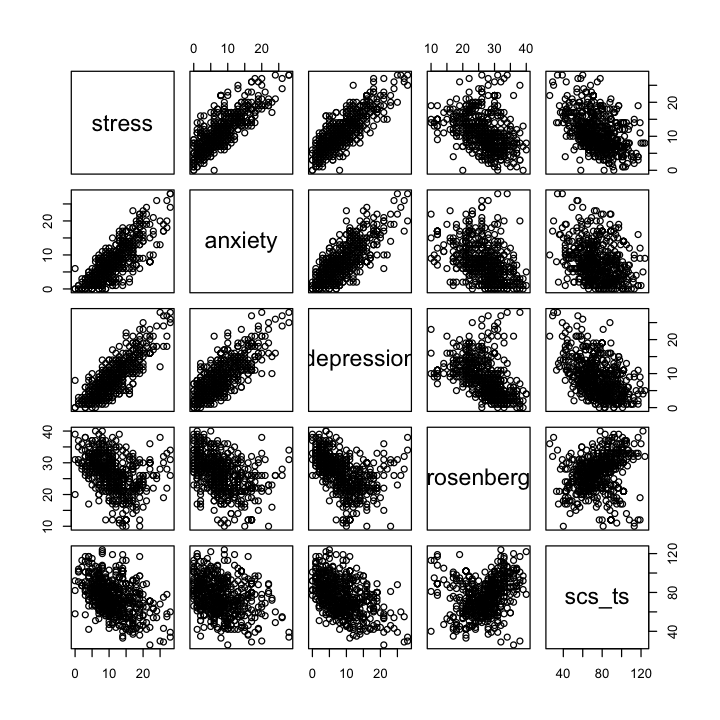

In [41]:
d <- dat |>
    dplyr::select(stress, anxiety, depression, rosenberg, scs_ts)

pairs(d)


In [42]:
y <- d$scs_ts |> as.matrix()
dim(y)

[1] 526   1

### Modello di Regressione Multipla

Il modello generale di regressione lineare multipla (MLR) può essere espresso tramite la seguente equazione:

$$
y_i = \beta_0 + \beta_1 x_{1i} + \cdots + \beta_p x_{pi} + \epsilon_i 
$$

dove $ i = 1, \ldots, N $ rappresenta l'osservazione $i$-esima, $ \beta_0 $ è il parametro di intercetta, $ \beta_1, \ldots, \beta_p $ sono i coefficienti di regressione, e $ \epsilon_i $ è un termine di errore per la risposta $i$. Inoltre, si assume che il termine di errore sia indipendente da tutte le variabili esplicative (o regressori) $ X_s $.

In questa formulazione, ogni $ y_i $ rappresenta il valore della variabile dipendente per l'osservazione $i$-esima, i $ \beta $ rappresentano i coefficienti che misurano l'impatto di ciascuna variabile esplicativa sulla variabile dipendente, e $ \epsilon_i $ cattura l'errore o la varianza non spiegata nella previsione di $ y_i $. Questa struttura permette di modellare la relazione lineare tra una variabile dipendente e più variabili indipendenti.

Il modello di regressione lineare multipla (MLR) espresso nell'equazione precedente viene spesso rappresentato nella seguente forma matriciale:

$$
y = X\beta + \epsilon 
$$

dove $ y $ è un vettore $ N \times 1 $ della variabile di risposta osservata, $ X $ è una matrice di progettazione (o design matrix) $ N \times (p+1) $ che include tutte le $ p $ variabili esplicative, con la prima colonna composta da 1 che rappresenta l'intercetta (cioè, $ \beta_0 $), $ \beta = (\beta_0, \beta_1, \ldots, \beta_p) $ è un vettore di $ (p+1) $ parametri di regressione, e $ \epsilon $ è il termine di errore. Specificamente, la matrice $ X $ e i vettori $ y $ e $ \epsilon $ sono definiti come segue:

$$
y = 
\begin{pmatrix}
y_1 \\
y_2 \\
\vdots \\
y_N
\end{pmatrix}, \quad
\epsilon = 
\begin{pmatrix}
\epsilon_1 \\
\epsilon_2 \\
\vdots \\
\epsilon_N
\end{pmatrix}, \quad
X = 
\begin{pmatrix}
1 & x_{11} & \cdots & x_{p1} \\
1 & x_{12} & \cdots & x_{p2} \\
\vdots & \vdots & \ddots & \vdots \\
1 & x_{1N} & \cdots & x_{pN}
\end{pmatrix} 
$$

In questa rappresentazione, ogni riga della matrice $ X $ corrisponde a un'osservazione e contiene i valori delle variabili esplicative per quell'osservazione, con una colonna aggiuntiva di 1 per l'intercetta. Il modello in forma matriciale consente un calcolo più efficiente dei parametri di regressione e una gestione più diretta delle relazioni tra variabili multiple.

### Metodo dei Minimi Quadrati

Fondamentalmente, stimando il parametro $ \beta $, cerchiamo di trovare valori (cioè, stime) per gli elementi in $ \beta $ in modo tale che la componente sistematica (cioè, $ X\beta $) spieghi quanto più possibile la variazione nella risposta (cioè, $ y $). In un certo senso, si tratta di trovare valori dei parametri che rendano l'errore il più piccolo possibile. In statistica, questo viene definito come stima dei minimi quadrati, cioè trovare $ \beta $ in modo che la somma degli errori al quadrato sia il più piccola possibile. Matematicamente, la stima dei minimi quadrati (LSE) di $ \beta $, indicata con $ \hat{\beta} $, si ottiene minimizzando la somma degli errori al quadrato (SSE):

$$
\text{SSE} = \epsilon_i^2 = \epsilon' \epsilon = (y - X\beta)'(y - X\beta) = y'y - 2\beta X'y + \beta'X'X\beta
$$

Prendendo la derivata della somma degli errori al quadrato (SSE) rispetto a $ \beta $ e impostandola a zero, si ottiene:

$$
X'X\hat{\beta} = X'y \quad (1.5)
$$

Se $ X'X $ è invertibile, allora abbiamo:

$$
\hat{\beta} = (X'X)^{-1}X'y
$$

In pratica, questo processo di minimizzazione degli errori al quadrato è fondamentale per la stima dei coefficienti nel modello di regressione lineare multipla. Lo scopo è di identificare i valori dei parametri che meglio descrivono la relazione tra le variabili indipendenti e la variabile dipendente, riducendo al minimo la discrepanza tra i valori osservati e quelli previsti dal modello.

Esaminiamo questi calcoli nel caso dei dati in considerazione.

In [43]:
dass <- d |>
    dplyr::select(depression, anxiety, stress)

In [44]:
X <- model.matrix(~ depression + anxiety + stress, data = dass)
head(X)

,(Intercept),depression,anxiety,stress
1,1,4,6,7
2,1,1,2,3
3,1,1,0,1
4,1,13,11,12
5,1,12,6,10
6,1,2,1,5


In [45]:
beta <- solve(t(X) %*% X) %*% t(X) %*% y
print(beta)

                  [,1]
(Intercept) 91.3611064
depression  -1.4841573
anxiety      1.0493140
stress      -0.9733368


Verifichiamo i calcoli eseguiti usando la funzione `lm()`:

In [46]:
fm <- lm(scs_ts ~ depression + anxiety + stress, data = d)
print(coef(fm))

(Intercept)  depression     anxiety      stress 
 91.3611064  -1.4841573   1.0493140  -0.9733368 


I valori predetti sono calcolati come:

In [47]:
yhat <- X %*% beta
cor(yhat, fm$fitted.values)

1


I residui si ottengono nel modo seguente:

In [48]:
e <- d$scs_ts - yhat
cor(e, fm$res)

1


La somma dei quadrati dei residui (Residual Sum of Squares, RSS) è definita nel modo seguente:

In [49]:
RSS <- t(e) %*% e

La stima della varianza dei residui è data da:

In [50]:
var_e <- RSS / (length(y) - dim(X)[2])

dove al denominatore abbiamo i gradi di libertà.

L'errore standard della regressione è dunque dato da:

In [51]:
sqrt(var_e)

15.70196


Verifichiamo:

In [52]:
summary(fm)


Call:
lm(formula = scs_ts ~ depression + anxiety + stress, data = d)

Residuals:
    Min      1Q  Median      3Q     Max 
-36.803 -12.000  -0.348  10.739  43.669 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  91.3611     1.6231  56.288  < 2e-16 ***
depression   -1.4842     0.2376  -6.247 8.69e-10 ***
anxiety       1.0493     0.2103   4.990 8.22e-07 ***
stress       -0.9733     0.2553  -3.813 0.000154 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 15.7 on 522 degrees of freedom
Multiple R-squared:  0.247,	Adjusted R-squared:  0.2426 
F-statistic: 57.06 on 3 and 522 DF,  p-value: < 2.2e-16


Infine, il coefficiente di determinazione nel modello di regressione multipla ha la stessa definizione di quello incontrato nella regressione bivariata:

In [53]:
R2 <- (sum((yhat - mean(y))^2)) / (sum((y - mean(y))^2)) 
R2

[1] 0.2469619

### Modello di Percorso

Formuliamo ora il modello di regressione multipla nei termini della path analysis.

In [54]:
mod <- "
  scs_ts ~ anxiety + depression + stress
"

Adattiamo il modello ai dati usando `lavaan`:

In [56]:
fit <- lavaan::sem(mod, d)

Esaminiamo i parametri ottenuti in questo modo:

In [57]:
parameterEstimates(fit)

lhs,op,rhs,est,se,z,pvalue,ci.lower,ci.upper
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
scs_ts,~,anxiety,1.0493140,0.2094644,5.009509,5.456903e-07,0.6387713,1.4598568
scs_ts,~,depression,-1.4841573,0.2366792,-6.270754,3.593039e-10,-1.9480401,-1.0202745
scs_ts,~,stress,-0.9733368,0.2543128,-3.827321,1.295457e-04,-1.4717808,-0.4748928
scs_ts,~~,scs_ts,244.6766292,15.0874073,16.217275,0.000000e+00,215.1058543,274.2474041
anxiety,~~,anxiety,32.0817418,0.0000000,NA,NA,32.0817418,32.0817418
anxiety,~~,depression,24.5464225,0.0000000,NA,NA,24.5464225,24.5464225
anxiety,~~,stress,24.5381096,0.0000000,NA,NA,24.5381096,24.5381096
depression,~~,depression,31.4182365,0.0000000,NA,NA,31.4182365,31.4182365
depression,~~,stress,25.6615608,0.0000000,NA,NA,25.6615608,25.6615608


Si noti che i parametri stimati in questo modo sono praticamente identici a quelli trovati con il metodo della massima verosimiglianza.

### Path Analysis e Scomposizione della Covarianza

L'obiettivo principale dei modelli SEM (Structural Equation Modeling) è quello di identificare coefficienti di percorso che permettano di ricostruire le covarianze osservate nel modello. Questo viene fatto attraverso la somma degli effetti diretti e indiretti, come specificato dal modello. Per esemplificare, consideriamo la covarianza tra il punteggio totale di self-compassion e il livello di ansia, come indicato dal DASS-21.

In questo contesto, l'effetto diretto si riferisce alla relazione diretta tra ansia e auto-compassione. Tuttavia, ci sono anche effetti indiretti che contribuiscono a questa relazione. Uno di questi effetti indiretti proviene dalla covarianza tra ansia e depressione, combinata con l'influenza della depressione sull'auto-compassione. Un altro effetto indiretto deriva dalla covarianza tra ansia e stress, combinata con l'effetto dello stress sull'auto-compassione.

In sostanza, nel modello SEM, la covarianza totale tra self-compassion e ansia è quindi una funzione:
1. Dell'effetto diretto dell'ansia sull'auto-compassione.
2. Dell'effetto combinato di ansia e depressione sull'auto-compassione.
3. Dell'effetto combinato di ansia e stress sull'auto-compassione.

Questi effetti vengono calcolati e sommati per fornire una stima complessiva della covarianza tra i due costrutti, offrendo una visione più olistica e dettagliata delle dinamiche psicologiche in gioco.

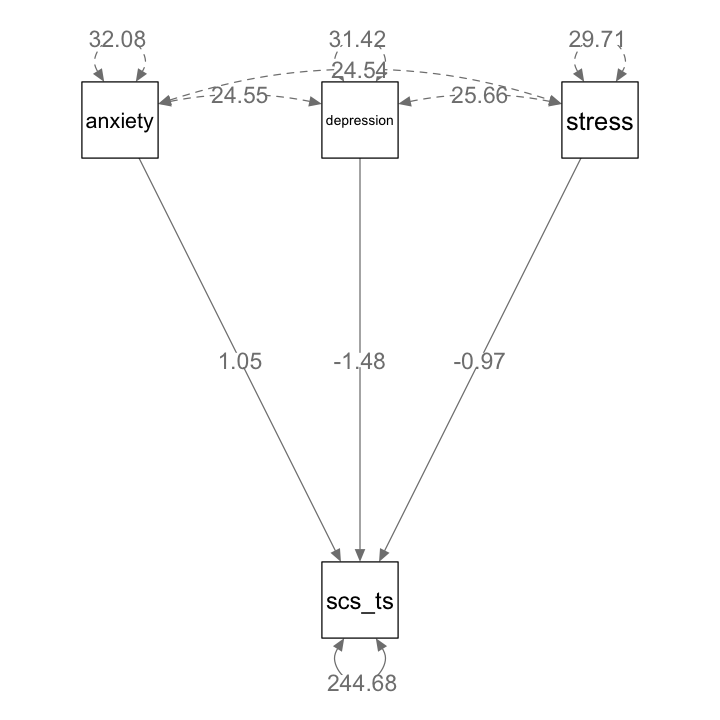

In [62]:
semPaths(fit,
    whatLabels = "est",
    sizeMan = 10,
    edge.label.cex = 1.15,
    style = "ram",
    nCharNodes = 0, nCharEdges = 0
)

In [63]:
# Coefficients from the model
beta_anxiety_scs_ts <- 1.0493140 # Coefficient for anxiety predicting scs_ts
beta_depression_scs_ts <- -1.4841573 # Coefficient for depression predicting scs_ts
beta_stress_scs_ts <- -0.9733368 # Coefficient for stress predicting scs_ts

# Covariances from the model
cov_anxiety_depression <- 24.5464225
cov_anxiety_stress <- 24.5381096
cov_depression_stress <- 25.6615608

# Assuming the variances of anxiety, depression, and stress
var_anxiety <- 32.0817418
var_depression <- 31.4182365
var_stress <- 29.7137880

# Predicted covariance between anxiety and scs_ts
predicted_cov_anxiety_scs_ts <- 
    beta_anxiety_scs_ts * var_anxiety +
    beta_depression_scs_ts * cov_anxiety_depression +
    beta_stress_scs_ts * cov_anxiety_stress

# Output the predicted covariance
print(predicted_cov_anxiety_scs_ts)


[1] -26.65078


Verifichiamo:

In [64]:
cov(d$anxiety, d$scs_ts)

[1] -26.70154

Lo stesso procedimento si usa per le altre componenti della matrice di varianza/covarianza dei dati.

## Valutazione della Bontà di Adattamento nel Modello SEM

Nel contesto dei modelli SEM (Structural Equation Modeling), la valutazione dell'adattamento del modello si basa sul confronto tra la matrice di varianze e covarianze stimata dal modello, $\Sigma(\hat{\theta})$, e la matrice di covarianza campionaria, $S$. Il nostro obiettivo è verificare se la discrepanza tra queste due matrici indica possibili inadeguatezze nel modello proposto. Ecco alcuni aspetti rilevanti da considerare:

- **Modelli Saturi vs Modelli Ristretti**: Un modello saturo include un numero di parametri in $\theta$ pari al numero di elementi distinti nella matrice di covarianza. In contrasto, un modello ristretto ha meno parametri rispetto al numero degli elementi distinti nella matrice di covarianza. La differenza tra questi due numeri corrisponde ai gradi di libertà del modello. Per esempio, in un modello saturo, se il numero dei parametri in $\theta$ e il numero degli elementi distinti nella matrice di covarianza sono entrambi 3, allora il modello ha zero gradi di libertà.

- **Perfetto Adattamento dei Modelli Saturi**: In un modello saturo, $\Sigma(\hat{\theta})$ coincide sempre con $S$, poiché il modello ha abbastanza parametri per adattarsi perfettamente ai dati del campione. Tuttavia, ciò non implica necessariamente che il modello rappresenti fedelmente la popolazione più ampia. Le stime dei parametri in un modello saturo possono fornire informazioni sui pattern di relazione tra le variabili nel campione specifico, ma è cruciale interpretarle con cautela.

- **Stima e Identificabilità del Modello**: Generalmente, la stima dei parametri non si basa sul semplice risolvere un sistema di equazioni matematiche. Invece, si utilizza una funzione di adattamento o discrepanza tra $\Sigma(\theta)$ e $S$, cercando il valore ottimale di $\hat{\theta}$ attraverso tecniche di ottimizzazione numerica. Un modello SEM deve essere identificabile, il che significa che deve essere possibile stimare univocamente i parametri del modello. L'identificabilità implica che il numero di unità di informazione, come elementi nella matrice di covarianza, sia maggiore o uguale al numero di parametri da stimare.

### Gradi di Libertà e Identificabilità del Modello

I gradi di libertà (dof) in un modello SEM sono calcolati come:

$$
dof = \# (\text{unità di informazione}) - \# (\text{parametri da stimare})
$$

Per una matrice di covarianza di ordine $ p $, il numero di unità di informazione è $ \frac{p (p+1)}{2} $. Per garantire l'identificabilità, è necessario soddisfare alcune condizioni:

1. In tutti i modelli, l'unità di misura delle variabili latenti deve essere specificata.
2. Il numero di unità di informazione deve essere uguale o superiore al numero di parametri da stimare.
3. In modelli ad un fattore, è richiesto un minimo di tre indicatori per una soluzione "appena identificata".
4. In modelli a più fattori, si raccomanda un minimo di tre indicatori per ogni variabile latente.

Un modello è:
- *Non identificato* se $ dof < 0 $.
- *Appena identificato* o "saturo" se $ dof = 0 $.
- *Sovra-identificato* se $ dof > 0 $.

È importante notare che un'analisi fattoriale con solo due indicatori per un fattore non è possibile, poiché ci sono meno unità di informazione rispetto ai parametri da stimare. Un modello con tre indicatori e un fattore è "appena identificato", senza gradi di libertà per valutare la bontà dell'adattamento. Per modelli ad un solo fattore comune latente, è quindi necessario disporre di almeno quattro indicatori.

### Funzione di Discrepanza e Valutazione della Bontà di Adattamento

La funzione di discrepanza tra $|S|$ e $|\Sigma(\theta)|$ basata sulla massima verosimiglianza (ML) deriva dalla verosimiglianza normale multivariata dei dati ed è formulata nel seguente modo:

$$
FML(S, \Sigma(\theta)) = \log|\Sigma(\theta)| - \log|S| + \text{traccia}(S\Sigma(\theta)^{-1}) - p
$$

dove $|S|$ e $|\Sigma(\theta)|$ sono i determinanti di $S$ e $\Sigma(\theta)$ rispettivamente, e $p$ è la dimensione di $S$ o $\Sigma(\theta)$. In questo contesto, $\log|\Sigma(\theta)|$ rappresenta il logaritmo del determinante della matrice di covarianza stimata dal modello, mentre $\log|S|$ è il logaritmo del determinante della matrice di covarianza campionaria. La "traccia" ($S\Sigma(\theta)^{-1}$) è la somma degli elementi della diagonale principale del prodotto di $S$ per l'inverso di $\Sigma(\theta)$. Questa funzione di discrepanza misura la differenza tra le covarianze osservate e quelle stimate dal modello, prendendo in considerazione sia le dimensioni delle matrici sia la loro forma.

La funzione di discrepanza basata sulla massima verosimiglianza (ML), come quella descritta dalla formula precedente, si distribuisce asintoticamente come una variabile casuale seguente una distribuzione chi quadrato (χ²) sotto l'ipotesi nulla che il modello specificato si adatti perfettamente ai dati.

La distribuzione chi quadrato è utilizzata per testare l'adattamento del modello nei contesti di modellazione di equazioni strutturali (SEM) e di analisi fattoriale. Il valore calcolato dalla funzione di discrepanza viene confrontato con un valore critico dalla distribuzione chi quadrato. Il numero di gradi di libertà per la distribuzione chi quadrato è tipicamente calcolato come la differenza tra il numero di stime indipendenti nella matrice di covarianza e il numero di parametri stimati nel modello.

Se il valore calcolato dalla funzione di discrepanza è inferiore al valore critico della distribuzione chi quadrato per i dati gradi di libertà, allora non si rifiuta l'ipotesi nulla e si conclude che il modello ha un buon adattamento. Se invece è maggiore, si rifiuta l'ipotesi nulla, indicando che il modello non si adatta bene ai dati.

In pratica, questo test è utilizzato per valutare la bontà di adattamento del modello ai dati osservati e per decidere se il modello specificato è adeguato o se sono necessarie ulteriori modifiche.

## Test $\chi^2$

Proseguendo la discussione precedente sulla valutazione dell'adattamento del modello, esaminiamo il test del chi quadrato (χ²) per la bontà di adattamento del modello. La statistica del chi quadrato è calcolata come il prodotto della dimensione del campione e della funzione di discrepanza minimizzata, ovvero χ² = N × Fmin. Alcuni software potrebbero usare (N-1) nel prodotto quando si adattano solo le strutture di covarianza.

Ricordiamo che l'ipotesi nulla testata è H0: Σ = Σ(θ). La statistica del chi quadrato viene utilizzata per determinare se il campione fornisce prove contro l'ipotesi nulla. Sotto l'ipotesi nulla di un vero modello nullo, la statistica del chi quadrato segue una distribuzione χ² con gradi di libertà specifici del modello. Quando il valore p-osservato della statistica del chi quadrato è molto piccolo (ad esempio, inferiore a un livello α convenzionale di 0,05), i dati presentano un evento estremo sotto H0. Un tale evento estremo (associato a un piccolo valore p) suggerisce che l'ipotesi nulla H0 potrebbe non essere sostenibile e dovrebbe essere rifiutata. Al contrario, più alto è il valore p associato al valore χ² osservato, più stretto è l'adattamento tra il modello ipotizzato (sotto H0) e l'adattamento perfetto (Bollen, 1989).

Tuttavia, la statistica del test del chi quadrato è sensibile alla dimensione del campione. Poiché la statistica χ² equivale a N × Fmin, questo valore tende ad essere sostanziale quando il modello non si adatta (anche minimamente) e la dimensione del campione è grande (Jöreskog e Sörbom, 1993). Il paradosso, tuttavia, è che l'analisi delle strutture di covarianza si basa sulla teoria dei grandi campioni. Di conseguenza, campioni grandi sono fondamentali per ottenere stime dei parametri precise, così come per la sostenibilità delle approssimazioni distribuzionali asintotiche (MacCallum et al., 1996).

Nonostante questi limiti, la statistica $\chi^2$ viene comunque utilizzata per altri scopi, come il confronto di modelli nidificati, il calcolo di altri indici di adattamento (ad es. l'indice di Tucker–Lewis) e il calcolo del rapporto tra $\chi^2$ e gradi di libertà. 

Sebbene la statistica $\chi^2$ sia riportata di routine nell'output dei software che svolgono la CFA, nella valutazione dell'adattamento del modello si fa solitamente affidamento su altri indici di adattamento. Tali indici possono essere suddivisi in tre categorie:

- *misure di adeguamento per il confronto* -- permettono di confrontare fra loro due o più modelli al fine di potere scegliere il modello (statisticamente) migliore;
- *misure di adeguamento parsimonioso* -- indici "aggiustati" in base ai gradi di libertà.
- *misure di adeguamento assoluto* -- indicano l'abilità del modello di riprodurre i dati osservati;

## Misure di adeguamento per il confronto

### CFI

Gli indici di *adattamento comparativo* [detti anche *indici di adattamento incrementale*; ad es. {cite:t}`hu1998fit`] valutano l'adattamento di una soluzione specificata dall'utente in relazione a un modello di base nidificato più ristretto. Tipicamente, il modello base è un modello "nullo" o "di indipendenza" in cui le covarianze tra tutti gli indicatori di input sono fissate a zero, ma nessun vincolo viene posto sulle varianze degli indicatori. 

Uno di questi indici, l'*indice di adattamento comparativo* (*comparative fit index*, CFI; Bentler, 1990), è calcolato come segue. Sia $\delta = \chi^2 - dof$, dove $dof$ sono i gradi di libertà di un particolare modello. Tanto più $\delta$ è prossimo allo zero tanto maggiore è la bontà dell'adattamento. La formula di CFI è

$$
\begin{equation}
CFI = \frac{\delta_B - \delta_T}{\delta_B},
\end{equation}
$$

dove il pedice $T$ denota il modello target (cioè il modello in valutazione) e il pedice $B$ denota il modello baseline (cioè il modello "nullo").

## Misure di adeguamento parsimonioso

### TLI 

Un indice che rientra nella degli indici di adeguamento parsimonioso è l'*indice Tucker-Lewis* (*Tucker–Lewis index*, TLI, anche chiamato indice di adattamento non normato). Il TLI si pone il problema di penalizzare la complessità del modello, ovvero include una funzione di penalizzazione per l'addizione di parametri che non migliorano in maniera sostanziale l'adattamento del modello. Il TLI è calcolato con la seguente formula:

$$
\begin{equation}
TLI = \frac{(\chi^2_B / dof_B)–(\chi^2_T / dof_T)}{(\chi^2_B / dof_B) – 1},
\end{equation}
$$

dove $\chi^2_T$ è il valore $\chi^2$ del modello target, $dof_T$ sono i gradi di libertà del modello target, $\chi^2_B$ è il valore $\chi^2$ del modello baseline e $dof_B$ sono i gradi di libertà del modello base.

## Misure di adeguamento assoluto

### RMSEA 

L'*errore quadratico medio di approssimazione* è una misura assoluta dell'adattamento perché non confronta la discrepanza del modello target rispetto a un modello di base, come CFI o TLI. Invece, RMSEA utilizza $\delta$ come parametro che misura il grado di errata specificazione del modello. Ricordiamo dalla discussione sull'indice CFI che $\delta = \chi^2 - df$, dove $df$ sono i gradi di libertà del modello. Tanto maggiore è $\delta$ tanto più grande è la mancanza di adattamento del modello ai dati. L'indice RMSEA si ottiene nel modo seguente:

$$
\begin{equation}
RMSEA = \sqrt{\frac{\delta}{dof \cdot (n-1)}},
\end{equation}
$$

dove $n$ corrisponde alla numerosità campionaria.

L'indice RMSEA fornisce una stima dell'errore di approssimazione che si
commette quando la matrice delle correlazioni (o covarianze) osservate viene riprodotta
tramite la matrice ricavata dalle saturazioni fattoriali. Questo indice rappresenta una stima della bontà di adattamento del modello nella popolazione,
ponderata per i gradi di liberà e quindi è una misura che tiene in
considerazione la parsimonia del modello. 

### RMRS

L'indice RMRS viene definito come la radice quadrata della media dei residui al quadrato. L'indice RMRS rappresenta la correlazione residua media, cioè non spiegata dal modello, ed è ricavabile con la seguente formula:

$$
\begin{equation}
RMRS = \sqrt{ \frac{2 \sum_i\sum_j(r_{ij} - \hat{r}_{ij})^2}{p(p+1)}},
\end{equation}
$$

dove $p$ è il numero di item, e $r_{ij}$ e $\hat{r}_{ij}$
sono rispettivamente la correlazione osservata e la correlazione
riprodotta tra le variabili $i$ e $j$.

### Interpretazione

Un valore RMSEA < .05 indica un "close fit" e quello < .08 suggerisce un ragionevole adattamento modello-dati. Bentler e Bonett (1980) raccomandano TLI > .90 per un adattamento accettabile.

L'interpretazione degli indici di bontà di adattamento trovati nella CFA o nella modellazione di equazioni strutturali può essere ottenuta usando le funzioni del pacchetto `effectsize`. Ad esempio (dal manuale):

In [28]:
structure <- " ind60 =~ x1 + x2 + x3
               dem60 =~ y1 + y2 + y3
               dem60 ~~ ind60 "
fit <- lavaan::sem(structure, data = lavaan::PoliticalDemocracy)
effectsize::interpret(fit)

Name,Value,Threshold,Interpretation
<chr>,<dbl>,<dbl>,<effctsz_>
GFI,0.96664121,0.95,satisfactory
AGFI,0.91243318,0.90,satisfactory
NFI,0.97486324,0.90,satisfactory
NNFI,1.00010307,0.90,satisfactory
CFI,1.00000000,0.90,satisfactory
RMSEA,0.00000000,0.05,satisfactory
SRMR,0.02726216,0.08,satisfactory
RFI,0.95286858,0.90,satisfactory
PNFI,0.51992706,0.50,satisfactory


## Un esempio concreto

Consideriamo nuovamente i dati discussi da {cite:t}`brown2015confirmatory` relativi al modello di misurazione per la depressione maggiore così come è definita nel DSM-IV. Ignoriamo qui le differenze di genere -- si veda il Capitolo {ref}`factorial-invariance-notebook`. 

Leggiamo i dati in $\mathsf{R}$:

In [ ]:
d <- readRDS(
    here::here("data", "mdd_sex.RDS")
)

Consideriamo il seguente modello:

In [ ]:
model_mdd <- "
  MDD =~ mdd1 + mdd2 + mdd3 + mdd4 + mdd5 + mdd6 + mdd7 + mdd8 + mdd9
"

Adattiamo il modello ai dati.

In [ ]:
fit <- cfa(
    model_mdd,
    data = d
)

Esaminiamo gli indici di bontà di adattamento.

In [ ]:
effectsize::interpret(fit)

Il rapporto $\chi^2 / df$ è adeguato.

In [ ]:
110.272 / 27

Gli indici Comparative Fit Index (CFI) = 0.934 e Tucker-Lewis Index (TLI) = 0.912 sono superiori a 0.9, dunque sono almeno sufficienti per gli standard correnti. L'indice RMSEA = 0.064 è appena superiore alla soglia di 0.06. L'indice SRMR = 0.044 è inferiore alla soglia 0.05. Dunque, complessivamente, il modello sembra adeguato.

Adattiamo ora il modello con la modifica proposta da {cite:t}`brown2015confirmatory`, ovvero

In [ ]:
model2_mdd <- "
  MDD =~ mdd1 + mdd2 + mdd3 + mdd4 + mdd5 + mdd6 + mdd7 + mdd8 +  mdd9
  mdd1 ~~ mdd2
"

fit2 <- cfa(
    model2_mdd,
    data = d
)

Esaminiamo gli indici di bontà di adattamento.

In [ ]:
effectsize::interpret(fit2)

In questa seconda versione, l'adattamento del modello è molto migliorato. Il rapporto $\chi^2 / df$ è pari a 

In [ ]:
67.559 / 26

Gli indici Comparative Fit Index (CFI) = 0.967 e Tucker-Lewis Index (TLI) = 0.954 sono superiori a 0.95. L'indice RMSEA = 0.046. L'indice SRMR = 0.037. 

Il "costo" che si paga per questo miglioramento dell'adattamento è che indici di adattamento così buoni, probabilmente, non si replicheranno in un altro campione di dati, a meno che venga introdotto un qualche altro aggiustamento che, sicuramente, sarà diverso da quello usato nel campione corrente. Personalmente, non avrei introdotto il "miglioramento" proposto da {cite:t}`brown2015confirmatory` in quanto, anche senza un tale aggiustamento post-hoc, il modello produce un adattamento accettabile.

## Commenti e considerazioni finali

Nella letteratura SEM sono state sollevate forti argomentazioni contro l'applicazione di RMSEA, CFI e TLI e i loro valori di cutoff convenzionali [si veda, ad esempio, {cite:t}`barrett2007structural`]. Tuttavia, prima che i ricercatori propongano e accettino alternative migliori, questi indici di bontà dell'adattamento continueranno ad essere applicati nella maggior parte degli studi SEM. {cite:t}`xia2019rmsea` fanno notare come, in base alla consuetudine corrente, valori RMSEA più grandi e valori CFI e TLI più piccoli indicano un adattamento peggiore. Ciò spinge i ricercatori a modificare i loro modelli per cercare di ottenere indici migliori. Tuttavia, la pratica attuale si è evoluta a tal punto da raggiungere la fase per cui gli indici di adattamento servono come *gli unici* criteri (in molte situazioni) per determinare se accettare o rifiutare un modello ipotizzato: se i valori degli indici di adattamento raggiungono la soglia "di pubblicabilità" (ad es. RMSEA < .06), allora non si ritiene più necessario migliorare il modello. In realtà, un'affermazione come la seguente non è sufficiente: "poiché i valori RMSEA, CFI e TLI suggeriscono un buon adattamento, questo modello è stato scelto come modello finale". Il raggiungimento di una serie di soglie desiderate di RMSEA, CFI e TLI è solo uno dei possibili indicatori che devono essere considerati nel processo di selezione di modelli. I ricercatori dovrebbero anche spiegare se esistono altre opzioni per migliorare il modello, perché tali opzioni sono o non sono adottate, e quali sono le conseguenze scientifiche e cliniche che derivano dalla scelta del modello in questione come quello finale.